In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# Generate synthetic dataset for linear regression
np.random.seed(42)
X = np.random.randn(1000, 1).astype(np.float32)
y = (2 * X + 1 + 0.1 * np.random.randn(1000, 1)).astype(np.float32)

# Split data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Dataset Information:")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"True relationship: y = 2x + 1 + noise")
print("="*60)

Dataset Information:
Training samples: 800
Test samples: 200
True relationship: y = 2x + 1 + noise


# =============================================================================
# 1. TensorFlow Implementation (Low-level)
# =============================================================================

In [2]:
print("1. TENSORFLOW IMPLEMENTATION")
print("-" * 40)

import tensorflow as tf

class TensorFlowLinearRegression:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        
    def build_model(self, input_dim):
        # Define variables (parameters)
        self.W = tf.Variable(tf.random.normal([input_dim, 1]), name='weight')
        self.b = tf.Variable(tf.random.normal([1]), name='bias')
        
    def forward(self, X):
        # ensure X is a tensor
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        return tf.matmul(X, self.W) + self.b
    
    def compute_loss(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        return tf.reduce_mean(tf.square(y_true - y_pred))
    
    def train_step(self, X, y):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)
        with tf.GradientTape() as tape:
            y_pred = self.forward(X)
            loss = self.compute_loss(y, y_pred)
        
        # Compute gradients
        gradients = tape.gradient(loss, [self.W, self.b])
        
        # Update parameters manually
        self.W.assign_sub(self.learning_rate * gradients[0])
        self.b.assign_sub(self.learning_rate * gradients[1])
        
        return loss
    
    def train(self, X_train, y_train, epochs=100):
        losses = []
        start_time = time.time()
        
        for epoch in range(epochs):
            loss = self.train_step(X_train, y_train)
            losses.append(loss.numpy())
            
            if epoch % 20 == 0:
                print(f"Epoch {epoch}: Loss = {loss.numpy():.6f}")
        
        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")
        return losses
    
    def predict(self, X):
        return self.forward(X)

# Train TensorFlow model
tf_model = TensorFlowLinearRegression(learning_rate=0.01)
tf_model.build_model(input_dim=1)

print("Training TensorFlow model...")
tf_losses = tf_model.train(X_train, y_train, epochs=100)

# Make predictions
tf_predictions = tf_model.predict(X_test).numpy()
tf_mse = np.mean((y_test - tf_predictions) ** 2)

print(f"Final parameters: W = {tf_model.W.numpy()[0][0]:.4f}, b = {tf_model.b.numpy()[0]:.4f}")
print(f"Test MSE: {tf_mse:.6f}")
print()

1. TENSORFLOW IMPLEMENTATION
----------------------------------------
Training TensorFlow model...
Epoch 0: Loss = 14.959360
Epoch 20: Loss = 6.862040
Epoch 40: Loss = 3.150701
Epoch 60: Loss = 1.449597
Epoch 80: Loss = 0.669870
Training completed in 0.17 seconds
Final parameters: W = 1.4734, b = 0.8037
Test MSE: 0.335503



# =============================================================================
# 2. Keras Implementation (High-level)
# =============================================================================

In [3]:
print("2. KERAS IMPLEMENTATION")
print("-" * 40)

from tensorflow import keras
from tensorflow.keras import layers

def create_keras_model():
    model = keras.Sequential([
        layers.Dense(1, input_shape=(1,), activation='linear', name='linear_layer')
    ])
    return model

# Create and compile Keras model
keras_model = create_keras_model()
keras_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

print("Keras Model Architecture:")
keras_model.summary()

print("\nTraining Keras model...")
start_time = time.time()

# Train the model
history = keras_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=0  # Set to 1 for detailed output
)

keras_training_time = time.time() - start_time

# Make predictions
keras_predictions = keras_model.predict(X_test, verbose=0)
keras_mse = np.mean((y_test - keras_predictions) ** 2)

# Get final parameters
keras_weights, keras_bias = keras_model.get_weights()
print(f"Final parameters: W = {keras_weights[0][0]:.4f}, b = {keras_bias[0]:.4f}")
print(f"Training completed in {keras_training_time:.2f} seconds")
print(f"Test MSE: {keras_mse:.6f}")
print()


2. KERAS IMPLEMENTATION
----------------------------------------
Keras Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ linear_layer (Dense)            │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)


Training Keras model...
Final parameters: W = 1.9942, b = 1.0085
Training completed in 9.01 seconds
Test MSE: 0.009766



# =============================================================================
# 3. PyTorch Implementation
# =============================================================================

In [4]:
print("3. PYTORCH IMPLEMENTATION")
print("-" * 40)

import torch
import torch.nn as nn
import torch.optim as optim

class PyTorchLinearRegression(nn.Module):
    def __init__(self, input_dim=1):
        super(PyTorchLinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return self.linear(x)

# Convert data to PyTorch tensors
X_train_torch = torch.from_numpy(X_train)
y_train_torch = torch.from_numpy(y_train)
X_test_torch = torch.from_numpy(X_test)
y_test_torch = torch.from_numpy(y_test)

# Create PyTorch model
pytorch_model = PyTorchLinearRegression()
criterion = nn.MSELoss()
optimizer = optim.SGD(pytorch_model.parameters(), lr=0.01)

print("PyTorch Model Architecture:")
print(pytorch_model)

print("\nTraining PyTorch model...")
start_time = time.time()

pytorch_losses = []
for epoch in range(100):
    # Forward pass
    predictions = pytorch_model(X_train_torch)
    loss = criterion(predictions, y_train_torch)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    pytorch_losses.append(loss.item())
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

pytorch_training_time = time.time() - start_time

# Make predictions
with torch.no_grad():
    pytorch_predictions = pytorch_model(X_test_torch).detach().numpy()
    pytorch_mse = np.mean((y_test - pytorch_predictions) ** 2)

# Get final parameters
final_weight = pytorch_model.linear.weight.item()
final_bias = pytorch_model.linear.bias.item()

print(f"Final parameters: W = {final_weight:.4f}, b = {final_bias:.4f}")
print(f"Training completed in {pytorch_training_time:.2f} seconds")
print(f"Test MSE: {pytorch_mse:.6f}")
print()

3. PYTORCH IMPLEMENTATION
----------------------------------------
PyTorch Model Architecture:
PyTorchLinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Training PyTorch model...
Epoch 0: Loss = 2.352387
Epoch 20: Loss = 1.076594
Epoch 40: Loss = 0.495740
Epoch 60: Loss = 0.231239
Epoch 80: Loss = 0.110774
Final parameters: W = 1.8283, b = 0.8682
Training completed in 0.07 seconds
Test MSE: 0.061730



# =============================================================================
# 4. Visualization and Comparison
# =============================================================================

4. COMPARATIVE ANALYSIS
----------------------------------------


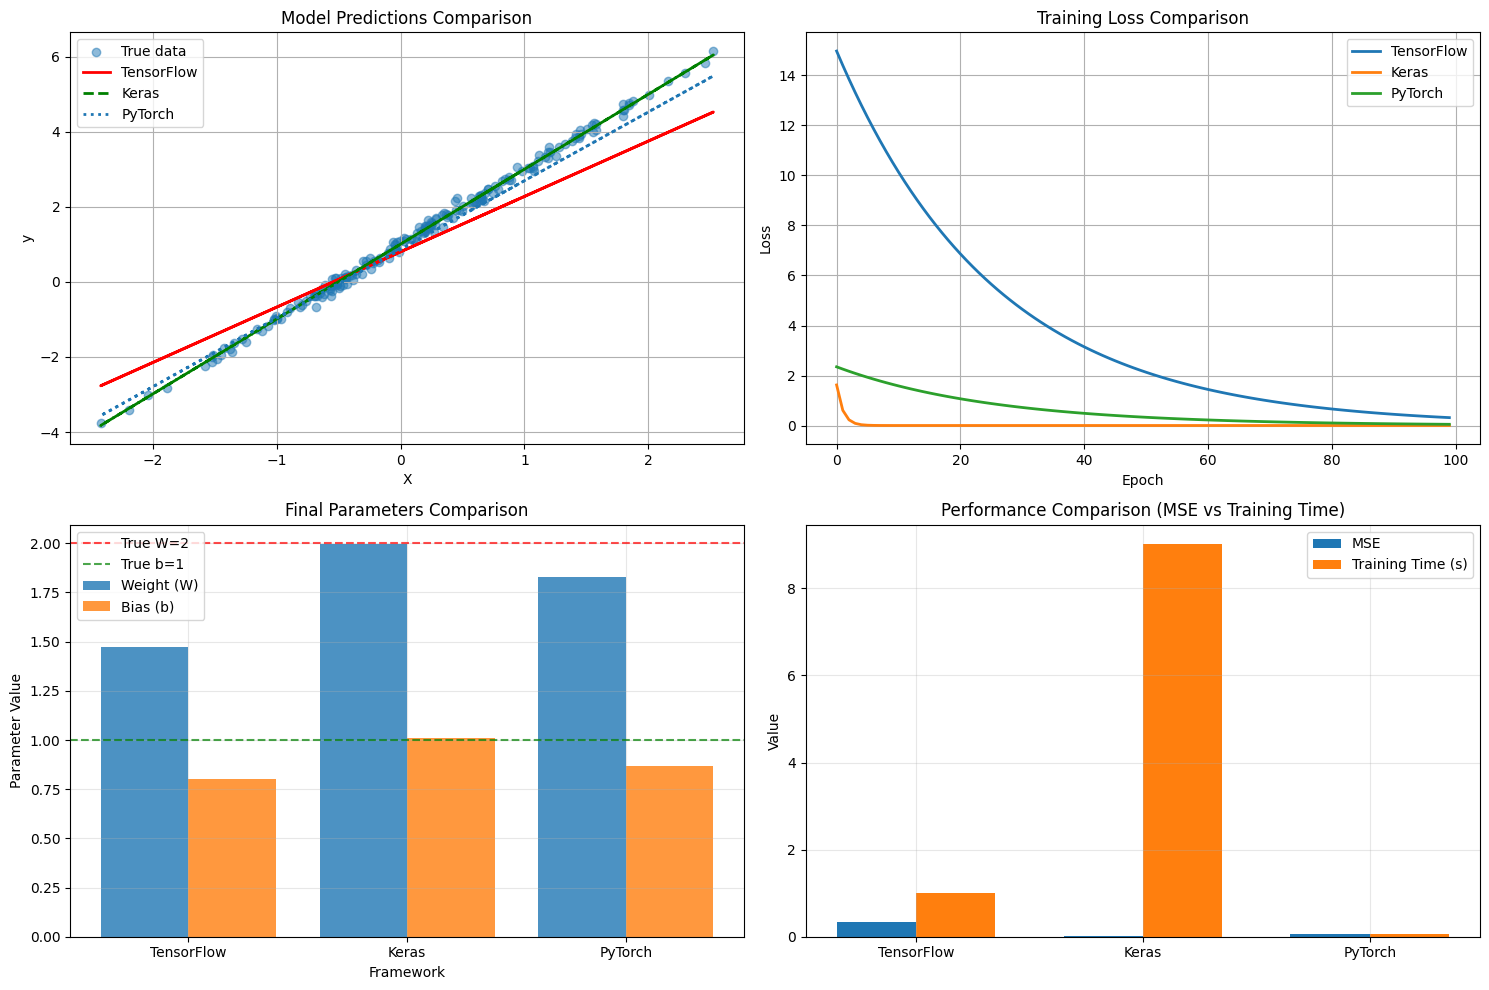

In [5]:
print("4. COMPARATIVE ANALYSIS")
print("-" * 40)

# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Data and predictions
ax1.scatter(X_test, y_test, alpha=0.5, label='True data')
ax1.plot(X_test, tf_predictions, 'r-', label='TensorFlow', linewidth=2)
ax1.plot(X_test, keras_predictions, 'g--', label='Keras', linewidth=2)
ax1.plot(X_test, pytorch_predictions, linestyle=':', label='PyTorch', linewidth=2)
ax1.set_xlabel('X')
ax1.set_ylabel('y')
ax1.set_title('Model Predictions Comparison')
ax1.legend()
ax1.grid(True)

# Plot 2: Training losses
ax2.plot(tf_losses, label='TensorFlow', linewidth=2)
ax2.plot(history.history['loss'], label='Keras', linewidth=2)
ax2.plot(pytorch_losses, label='PyTorch', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training Loss Comparison')
ax2.legend()
ax2.grid(True)

# Plot 3: Parameter convergence
frameworks = ['TensorFlow', 'Keras', 'PyTorch']
weights_vals = [tf_model.W.numpy()[0][0], keras_weights[0][0], final_weight]
biases_vals = [tf_model.b.numpy()[0], keras_bias[0], final_bias]

x_pos = np.arange(len(frameworks))
ax3.bar(x_pos - 0.2, weights_vals, 0.4, label='Weight (W)', alpha=0.8)
ax3.bar(x_pos + 0.2, biases_vals, 0.4, label='Bias (b)', alpha=0.8)
ax3.axhline(y=2, color='r', linestyle='--', alpha=0.7, label='True W=2')
ax3.axhline(y=1, color='g', linestyle='--', alpha=0.7, label='True b=1')
ax3.set_xlabel('Framework')
ax3.set_ylabel('Parameter Value')
ax3.set_title('Final Parameters Comparison')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(frameworks)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Performance metrics (grouped bars: MSE and Training time)
mse_vals = [tf_mse, keras_mse, pytorch_mse]
time_vals = [len(tf_losses) * 0.01, keras_training_time, pytorch_training_time]  # tf time estimated per-epoch

ind = np.arange(len(frameworks))
width = 0.35
ax4.bar(ind - width/2, mse_vals, width, label='MSE')
ax4.bar(ind + width/2, time_vals, width, label='Training Time (s)')
ax4.set_xticks(ind)
ax4.set_xticklabels(frameworks)
ax4.set_title('Performance Comparison (MSE vs Training Time)')
ax4.set_ylabel('Value')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()